In [1]:
import sys
import os

import json
import gc

import pickle

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = os.path.abspath(os.path.join('..','pubmed_data'))
if module_path not in sys.path:
    sys.path.append(module_path)

    
import pubmed_data.pubmed_helper as ph

In [2]:
#Time to read pubmed_final.tar.gz: +/- 5min

articles = ph.read_pubmed_collection("/backup/pubmed_archive_json/pubmed_ready.tar.gz")

Preparing the tar.gz... should take few minutes
File pubmed_ready_00000000_to_02776362 : Done
File pubmed_ready_02776363_to_05519968 : Done
File pubmed_ready_05519969_to_08241071 : Done
File pubmed_ready_08241072_to_11124313 : Done
File pubmed_ready_11124314_to_13996815 : Done
File pubmed_ready_13996816_to_18824354 : Done


In [3]:
print("Number of articles:",len(articles))

Number of articles: 18824355


In [4]:
i=0
def progress(x):
    global i

    if i%10000==0:
        print( "Articles done:",i,end="\r")
    i+=1
    return x["title"]+" "+x["abstract"]

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer

LOAD_TOKENIZER = True
#tokenizer_file_name = "bllip_N10_tokenizer_full_pubmed.p"
#tokenizer_file_name = "/backup/pubmed_tokenizers/bllip_stopW_stem_N10_tokenizer_full_pubmed.p"

if LOAD_TOKENIZER:
    tokenizer =  ph.load_tokenizer(mode="bllip_stem")
else:
    #The char '-' was not included in the filter
    tokenizer = Tokenizer(filters='!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n',oov_token="<UNK>")

    articles_plain_text = map(progress,articles)

    tokenizer.fit_on_texts(articles_plain_text)

    import pickle
    #save tokenizer
    
    pickle.dump(tokenizer,open(tokenizer_file_name,"wb"))

Number of words in vocabulary: 11108739


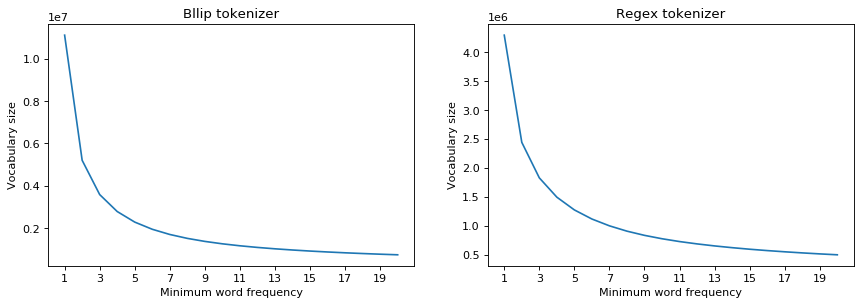

In [24]:
print("Number of words in vocabulary:",len(tokenizer.word_index))

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np

%matplotlib inline
def plot_data(tokenizer):
    number_less_frequent_words = list(range(2,21))

    _temp = tokenizer.word_counts.items()
    voc_size_by_less_frequent_words = [len(_temp)]
    for f in number_less_frequent_words: #2-10
        #for f=1 this is stupid!!
        print("Frequence greater than",f)
        _temp = list(filter(lambda x:x[1]>=f,_temp))
        voc_size_by_less_frequent_words.append(len(_temp))

    number_less_frequent_words = [1] + number_less_frequent_words    
    
    return number_less_frequent_words, voc_size_by_less_frequent_words

#bllip_tokenizer = ph.load_tokenizer(mode="bllip_stem_full_tokens")
#regex_tokenizer = ph.load_tokenizer(mode="regex_full_tokens")
#bllip_x,bllip_y = plot_data(bllip_tokenizer)
#regex_x,regex_y = plot_data(regex_tokenizer)


figure(num=None, figsize=(13, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.title("Bllip tokenizer")
plt.xticks(np.arange(min(number_less_frequent_words), max(number_less_frequent_words)+1, 2.0))
plt.xlabel("Minimum word frequency")
plt.ylabel("Vocabulary size")
plt.plot(bllip_x, bllip_y)

plt.subplot(1, 2, 2)

plt.xticks(np.arange(min(number_less_frequent_words), max(number_less_frequent_words)+1, 2.0))
plt.title("Regex tokenizer")
plt.xlabel("Minimum word frequency")
plt.ylabel("Vocabulary size")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(regex_x, regex_y)




#plt.plot(number_less_frequent_words,voc_size_by_less_frequent_words)
plt.savefig('bllip_regex_freq.png', bbox_inches='tight')

In [5]:
N = 20

#tokenizer.num_words = N

l=sorted(filter(lambda x:x[1]>=N,tokenizer.word_counts.items()),key=lambda x:-x[1])

print(len(l))

print(l[:50])

744568
[('.', 222577195), ('patient', 20574655), ('use', 16084915), ('studi', 15842610), ('cell', 15118150), ('0', 13708461), ('result', 12215874), ('1', 11229385), ('effect', 10510522), ('2', 10106007), ('activ', 9451227), ('group', 8821562), ('increas', 8616392), ('differ', 7690949), ('method', 7392476), ('treatment', 7197371), ('3', 7131147), ('p', 7081695), ('level', 6616202), ('protein', 6337041), ('associ', 6232811), ('show', 6108979), ('express', 6060673), ('5', 6001651), ('compar', 5841788), ('diseas', 5804515), ('control', 5799019), ('clinic', 5479717), ('may', 5467208), ('develop', 5425885), ('two', 5392458), ('function', 5325815), ('4', 5271894), ('also', 5200390), ('case', 5121379), ('respons', 5039963), ('gene', 5012633), ('measur', 4931261), ('present', 4867719), ('factor', 4851994), ('analysi', 4790309), ('data', 4725378), ('model', 4685269), ('rate', 4671810), ('system', 4630223), ('signific', 4551802), ('test', 4432010), ('conclus', 4428722), ('suggest', 4407635), ('re

In [7]:
N = 20
max_vocabulary = len(list(filter(lambda x:x[1]>=N,tokenizer.word_counts.items())))

print(max_vocabulary)

tokenizer.num_words = max_vocabulary + 1
with open("/backup/pubmed_tokenizers/bllip_stopW_stem_N10_tokenizer_full_pubmed.p","wb") as f:
    pickle.dump(tokenizer,f)

744568


In [24]:
from nltk.corpus import stopwords

st_Words =  set(stopwords.words('english'))

voc = set(map(lambda x:x.lower(),tokenizer.word_index.keys()))

In [22]:
from bllipparser import tokenize
tokenizer.num_words = None#3e6
len(tokenizer.texts_to_sequences(["BACKGROUND: Oral naltrexone's effectiveness as an opioid antagonist has been limited due to poor patient adherence. A long-acting naltrexone formulation may be beneficial. This study evaluated the effects of extended-release injectable naltrexone (XR-NTX), targeted for a one-month duration of action, in blocking opioid agonist challenge effects in humans."])[0])
#tokenize("fibrogenic, -LSB-uridine, conna! hello?,  final. outro final\nCyp2c9-dependent ecto-enzyme.".lower())

55

In [7]:
SINGLE_THREAD_TOKENIZATION = True

if SINGLE_THREAD_TOKENIZATION:
    i=0
    articles_plain_text = map(progress,articles)
    tokenized_articles = tokenizer.texts_to_sequences(articles_plain_text)
    del articles
    gc.collect()
else:
    ### SPEED UP NOT ACHIVED!!!!
    ### DONT USE
    import threading
    import time
    
    tokenized_results = {}
    #Thread class
    class TokenizeThread (threading.Thread):
        def __init__(self, threadID, tokenizer,articles,start_end):
            threading.Thread.__init__(self)
            self.threadID = threadID
            self.thread_progress = 0
            self.tokenizer = tokenizer
            self.tokenized_result = None
            self.articles = articles
            self.start_end = start_end


        def run(self):
            time.sleep(1)#Wait 1 sec before start, to manual sync with the main print
            print("Thread",self.threadID,"STARTED")
            def progress(x):
                #DEBUG FOR SINGLE THREAD
                if self.threadID==0 and self.thread_progress%10000==0:
                    print( "Articles done:",self.thread_progress,end="\r")
                self.thread_progress+=1
                return x["title"]+" "+x["abstract"]
            
            #ALL THREADS RUN THIS
            self.tokenized_result = self.tokenizer.texts_to_sequences(map(progress,self.articles[self.start_end[0]:self.start_end[1]]))
            print("Thread",self.threadID,"ENDED")
    
    #thread info and data splitting
    N_threads = 10
    
    batch = list(range(0,len(articles),int(len(articles)//N_threads)))
    batch[-1] = len(articles)-1 #ajust the last index
    
    threads = []
    #Thread start!
    for i in range(N_threads-1):
        tt = TokenizeThread(i,tokenizer,articles,(batch[i],batch[i+1])) 
        threads.append(tt)
        tt.start()
        
    print("Wait for the working threads")
    for t in threads:
        t.join()
    

In [20]:
whos

Variable                          Type         Data/Info
--------------------------------------------------------
LOAD_TOKENIZER                    bool         True
N                                 int          11
Tokenizer                         type         <class 'tensorflow.python<...>ocessing.text.Tokenizer'>
f                                 int          20
gc                                module       <module 'gc' (built-in)>
json                              module       <module 'json' from '/usr<...>hon3.5/json/__init__.py'>
l                                 list         n=1369434
module_path                       str          /home/tiagoalmeida/bioASQ-taskb/pubmed_data
np                                module       <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
number_less_frequent_words        list         n=20
os                                module       <module 'os' from '/usr/lib/python3.5/os.py'>
ph                                module       <module 'pubm

## Count 2-grams word in order to compute the Mutual information of each 2-gram

In [8]:
from collections import defaultdict

LOAD_TWO_GRAM=False

if LOAD_TWO_GRAM:
    two_gram_words = pickle.load(open("two_gram_words.p","rb"))
else:
    two_gram_words = defaultdict(int) #default value is 0

    for e,doc in enumerate(tokenized_articles):
        if e%10000==0:
            print("Articles:",e, end="\r")
        for i in range(len(doc)-1):
            two_gram_words[(doc[i],doc[i+1])] += 1
            
    pickle.dump(two_gram_words,open("two_gram_words.p","wb"))
        

In [12]:
tokenizer.invert_word_index = {v:k for k,v in tokenizer.word_index.items()}

## Data-driven Approach
\begin{equation}
score(X,Y)=\frac{\#(X,Y)-\gamma}{\#(X)*\#(Y)}
\end{equation}

$\gamma$ - discount parameter for rare words

$\#$ - counting function

In [13]:
gamma = 5 #rare words

score_mi = {}

for words,count in two_gram_words.items():
    if count<=20: #speed up and save memory
        continue
    x = tokenizer.invert_word_index[words[0]]
    y = tokenizer.invert_word_index[words[1]]
    score_mi[(x,y)] =  (count - gamma)/ (tokenizer.word_counts[x]*tokenizer.word_counts[y])

In [14]:
print(len(score_mi))
sort_scores=sorted(score_mi.items(),key=lambda x:-x[1])

7080176


In [16]:
#sort_scores[:50]
print(len(tokenizer))

10055342


## Normalize Pointwise mutual information

\begin{equation}
NPMI(X,Y) = \frac{log\left (\frac{p(X,Y)}{p(X)* p(Y)} \right )}{-log(p(X,Y))}
\end{equation}

$p(X)=\frac{\#X}{\#Words}$, $p(Y)=\frac{\#Y}{\#Words}$, $p(X,Y)=\frac{\#X+\#Y}{\#Words}$

where $Words$ correspond to the number of words

In [33]:
import math

score_pmi = {}

t_words = sum(tokenizer.word_counts.values())

for words,count in two_gram_words.items():
    if count<=20: #speed up and save memory
        continue
    x = tokenizer.invert_word_index[words[0]]
    y = tokenizer.invert_word_index[words[1]]
    p_x = tokenizer.word_counts[x]/t_words
    p_y = tokenizer.word_counts[y]/t_words
    p_x_y = count/t_words
    score_pmi[(x,y)] =  math.log(p_x_y/(p_x*p_y))/-math.log(p_x_y)

In [34]:
print(len(score_pmi))
sort_scores=sorted(score_pmi.items(),key=lambda x:-x[1])

7080176


In [35]:
sort_scores[:50]

[(('k670m', 'n671l'), 18.828423545036248),
 (('etiprednol', 'dicloacetate'), 18.781903529401358),
 (('hydrurga', 'leptonyx'), 18.781903529401358),
 (('perosomus', 'elumbis'), 18.737451766830524),
 (('raav8-1', '3hbv'), 18.73745176683052),
 (('risus', 'sardonicus'), 18.694892152411725),
 (('sekuru', 'kaguvi'), 18.694892152411725),
 (('prm1--', 'prm2--'), 18.694892152411725),
 (('weekday-on', 'weekend-off'), 18.694892152411725),
 (('sucrose-potassium', 'phosphate-glyoxylic'), 18.694892152411725),
 (('rathu', 'heenati'), 18.694892152411725),
 (('9a-hexahydro-6', '9-methano-2'), 18.69093175119563),
 (('biolumin', 'chemilumin'), 18.65407015789147),
 (('cintredekin', 'besudotox'), 18.65407015789147),
 (('r278995', 'cra0450'), 18.65407015789147),
 (("6'-dimethylene", 'dioxybiphenyl-2'), 18.646479988624797),
 (('lijecnicki', 'vjesnik'), 18.61484944473819),
 (('shuanggu', 'yitong'), 18.61484944473819),
 (('tricosa-10', '12-diynoyl'), 18.61484944473819),
 (('n-mecys3', 'n-mecys7'), 18.5771091167

In [ ]:
#%%javascript
#Jupyter.notebook.session.delete();

## THIS IS TEST CODE and it do not belong to this notebook!

In [85]:
s_tokens=tokenizer.texts_to_sequences([s])

In [86]:
s_tokens

[[2922, 137, 229, 2560, 14825, 14825, 14825, 95, 817, 10, 1582]]

In [83]:
s = 'Outpatient non-dependent opioid abusers abusers  abusers (N=27) were randomly'

In [91]:
tf_idf=tokenizer.sequences_to_matrix(s_tokens,mode="tfidf")

In [108]:
indexs = [ i for i,weight in enumerate(tf_idf[0,:]) if weight != 0]

In [111]:
from collections import defaultdict
token_counts = defaultdict(int)

for token in s_tokens[0]:
    token_counts[token] += 1

tf_idf_token = {}
for token,count in token_counts.items():
    tf_idf_token[token] = count * np.log(tokenizer.document_count/(tokenizer.index_docs[token]))#(1 + np.log(count)) * np.log(1 + tokenizer.document_count / (1 + tokenizer.index_docs.get(token, 0)))


In [112]:
tf_idf_token

{10: 0.5540891613639597,
 95: 2.440419401685922,
 137: 2.3728192143148448,
 229: 2.671217611728552,
 817: 3.5418946740938666,
 1582: 4.129167097606139,
 2560: 5.70268568158756,
 2922: 5.154108008796186,
 14825: 23.288221311393624}

In [110]:
tf_idf[0,indexs]

array([ 1.00808745,  2.52395483,  2.46194395,  2.73809766,  3.57044002,
        4.14513213,  5.7060021 ,  5.15985837, 16.29162677])

In [3]:
##Steming tokenizer words

In [10]:
from nltk.stem import PorterStemmer
st = PorterStemmer()

for i,t in enumerate(tokenizer.word_counts.items()):
    st.stem(t[0])
    if i%10000==0:
        print(i,end="\r")

stem_vocab =  

In [11]:
len(tokenizer.word_counts)

12086336